## Analysing Competition Influence on Fake Reviews

This sections aims to analyse the influence of restaurant competition on fake reviews. More specifically, we want to find out how local competition between restaurants of the same and different categories affects the number of positive and negative fake reviews that restaurants receive.

### Importing and Cleaning Data

In [1]:
import json

import numpy as np
import pandas as pd
import plotly.express as px
import requests
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [2]:
df_rest = pd.read_csv("./../datasets/enh_restaurants/enh_restaurants.csv.zip", index_col=0)
df_review = pd.concat(
    [
        pd.read_csv("./../datasets/enh_reviews/enh_reviews.csv.zip", index_col=0),
        pd.read_csv("./../datasets/enh_freviews/enh_freviews.csv.zip", index_col=0),
        #pd.read_csv("./../datasets/proc_reviews/proc_reviews.csv.zip", index_col=0),
        #pd.read_csv("./../datasets/raw_freviews/raw_freviews.csv.zip", index_col=0)
    ],
    ignore_index=True
)

### Setting-up Competition Metrics

In this section, we will calculate a competition metric for restaurants. We based our calculations on the article *Fake It Till You Make It: Reputation, Competition, and Yelp Review Fraud*. Our competition metric, therefore, will be based on the distance between restaurants and if they belong to the same category.

#### Calculating the distance between restaurants

To calculate the distance between restaurants, we will use the Haversine function to obtain an approximation of the distance between two coordinates. With this function, we can build a distance matrix, which is a symmetric square matrix $M$, where each element $M_{i,j}$ contains the distance between restaurants $i$ and $j$.

In [3]:
from scipy.spatial.distance import pdist, squareform
from math import cos, sin, asin, sqrt
import time

def haversine(x1, x2):
    
    # convert degrees to radians
    lat1, lon1 = np.radians(x1)
    lat2, lon2 = np.radians(x2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of earth in kilometers is 6371
    km = 6371* c
    
    return km

def build_distance_matrix(df_rest):
    locations = df_rest[['coordinates.latitude', 'coordinates.longitude']]
    distances = pdist(locations, metric=haversine)
    distance_matrix = squareform(distances)
    
    return distance_matrix

#### Computing the category similarities between restaurants

Our goal here is to build a category matrix, which is a square matrix $M$ where each element $M_{i,j}$ contains a boolean value that indicates if restaurants $i$ and $j$ have at least one category in common. 

In [4]:
def build_category_matrix(df_rest):
    categories = df_rest['categories'].apply(eval).apply(set)
    category_matrix = [categories.apply(lambda c2: len(c1.intersection(c2)) != 0) for c1 in categories]
    
    return np.array(category_matrix)

#### Computing a competition metric for restaurants

Finally, we will use the distance matrix and the category matrix to build a metric for the competition experienced by each restaurant. First of all, we build a build a matrix that measures the competition between every two restaurants. This matrix is a symmetric matrix $M$ where each element $M_{i,j}$ contains a function that is inversely related to the distance between restaurants $i$ and $j$. We used the same function as the article cited above:

$$ M_{i,j} = exp \left({-\frac{1}{2}\left(\frac{d_{i,j}}{h}\right)^2}\right) $$

where $d$ is the distance between the restaurants and $h$ is a positive parameter (function bandwidth). This way, the further away the restaurants are from each other, the lesser the influence on the competition.

After that, we compute a vector that contains, for each resturant, the metric that measures the competition experienced by every restaurant. Indeed, we compute two vectors: one that represents competition caused by restaurants of the same category and other that represents competition experienced by restaurants of different categories. Therefore, the competition vector $w$ contains the metric $w_i$ for each restaurant $i$, which computed as follows:

$$ w_i = \sum_{j \neq i} {M_{i, j} \mathbb{1} _{\text{same category}_{i,j}}} $$

or

$$ w_i = \sum_{j \neq i} {M_{i, j} \mathbb{1} _{\text{different category}_{i,j}}} $$

In [5]:
def build_competition_variables(df_rest, h):
    print('building distance matrix...')
    
    distance_matrix = build_distance_matrix(df_rest)
    
    competition_matrix_same_category = np.exp(-0.5 * np.power(distance_matrix * 1/(2*h), 2))
    competition_matrix_diff_category = np.exp(-0.5 * np.power(distance_matrix * 1/h, 2))
    
    np.fill_diagonal(distance_matrix, 0)
    
    print('done. Building category matrix...')
    
    category_matrix = build_category_matrix(df_rest)
    
    print('done. Building competition variable matrices')
    
    competition_same_category = np.sum(competition_matrix_same_category * category_matrix, axis=1)
    competition_diff_category = np.sum(competition_matrix_diff_category * (~category_matrix), axis=1)
    
    print('done.')
    return competition_same_category, competition_diff_category

#### Analyzing competition metrics for a subset of the data

Now, let's test to see how the competition metrics behave for restaurant 0 using a subset of our data.

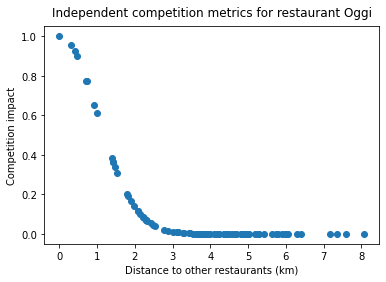

In [6]:
# get subset of df_rest
df_test = df_rest.sample(100).dropna(subset=['coordinates.latitude', 'coordinates.longitude', 'freview_count']).reset_index(drop=True)

# set bandwidth to 1
h=1

# compute distance matrix and competition metric matrix
distance_matrix = build_distance_matrix(df_test)
comp_metric = np.exp(-0.5 * np.power(distance_matrix * 1/h, 2))

# compute values for restaurant in index 0
distances_rest0 = distance_matrix[0,:]
comp_metric_rest0 = comp_metric[0,:]

# get the name of restaurant 0
name = df_test['name'][0]

# plot distance x competition for restaurant 0
plt.figure()
plt.title(f'Independent competition metrics for restaurant {name}', pad=10)
plt.xlabel('Distance to other restaurants (km)')
plt.ylabel('Competition impact')
plt.scatter(distances_rest0, comp_metric_rest0)
plt.show()

Let's also see how competition behaves and how it varies from arrondissement to arrondissement.

building distance matrix...
done. Building category matrix...
done. Building competition variable matrices
done.


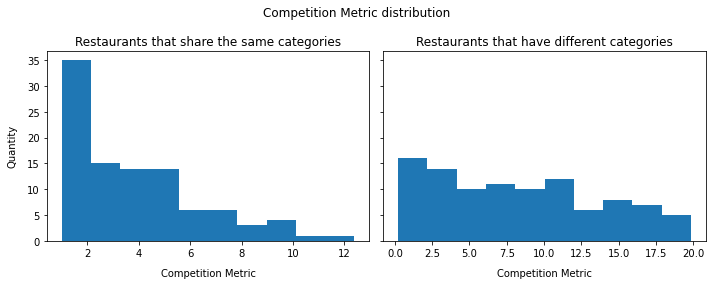

In [7]:
# get subset of df_rest
df_test = df_rest.sample(100).dropna(subset=['coordinates.latitude', 'coordinates.longitude', 'freview_count']).reset_index(drop=True)

competition_same_category, competition_diff_category = build_competition_variables(df_test, h=1)

comp = pd.DataFrame(np.array([competition_same_category, competition_diff_category]).T)
comp.columns = ['competition.same_category', 'competition.diff_category']

df_test = pd.concat([df_test, comp], axis=1)

fig, ax = plt.subplots(1,2,sharey = True, figsize=(10,4))

fig.suptitle('Competition Metric distribution')

ax[0].hist(competition_same_category)
ax[0].set_title('Restaurants that share the same categories')
ax[0].set_xlabel('Competition Metric', labelpad=10)
ax[0].set_ylabel('Quantity', labelpad=10)

ax[1].hist(competition_diff_category)
ax[1].set_title('Restaurants that have different categories')
ax[1].set_xlabel('Competition Metric', labelpad=10)

plt.tight_layout()
plt.show()

In the plots above, we can see that restaurants that share the same categories tend to have lower competition impact on each other, since they are usually further away. On the other hand, restaurants that do not share the same category have almost a uniform impact, since they are distributed across the city.

/home/josebarretto/anaconda3/envs/mods203/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


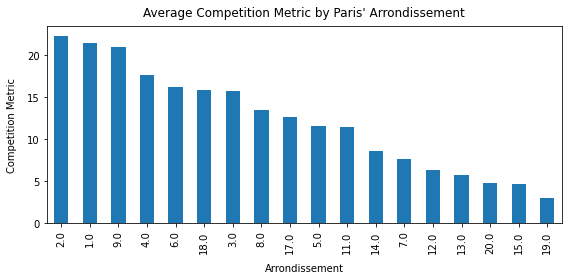

In [8]:
comp = df_test[['arrondissement', 'competition.same_category', 'competition.diff_category']]

comp['competition.total'] = comp['competition.same_category'] + comp['competition.diff_category']

grouped = comp.groupby('arrondissement').mean().reset_index()
grouped.sort_values('competition.total', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (8,4))

grouped.plot.bar(x='arrondissement', y='competition.total', ax=ax, legend=False)

ax.set_xlabel('Arrondissement', labelpad=10)
ax.set_ylabel('Competition Metric', labelpad=10)
ax.set_title('Average Competition Metric by Paris\' Arrondissement', pad=10)
plt.tight_layout()
plt.show()

That's a great metric to look at if you're planning on opening a new restaurant and don't want to face much competition!

### Understanding How Competition Affects Fake Reviews

In this section, we want to discover the competition effects on positive and negative fake reviews. For this reason, we have to do some cleaning on the data. When we were scraping Yelp for fake reviews, we only managed to obtain a maximum of ten fake reviews per restaurant. However, we know the correct fake review count for every one of them. Since we want to separate the fake reviews based on their content, we are obliged to remove the restaurants where we didn't collect all the fake reviews.

In [32]:
# get subset of df_rest
df_test = df_rest.dropna(subset=['coordinates.latitude', 
                                 'coordinates.longitude', 
                                 'freview_count']).reset_index(drop=True)

# exclude restaurants for which we didn't scrape all fake reviews
real_review_count = df_review.groupby('business.alias').count().reset_index()[['business.alias', 'rating']]
real_review_count.rename(columns={'rating': 'real_review_count'}, inplace=True)
df_test = df_test.merge(real_review_count, how='inner', left_on='alias', right_on='business.alias')
mask = df_test['treview_count'] == df_test['real_review_count']
df_test = df_test[mask]

Compute number of negative fake reviews for each restaurant.

In [33]:
# filter out non negative reviews
negative_freviews = df_review['rating'] <= 2

# filter out non fake reviews
df_negative_freviews = df_review[negative_freviews]
df_negative_freviews = df_negative_freviews[df_negative_freviews['is_fake']]

# obtain count of negative fake reviews and merge with test dataframe
negative_freview_count = df_negative_freviews.groupby('business.alias').count().reset_index()
negative_freview_count = negative_freview_count[['business.alias', 'rating']]
negative_freview_count.rename(columns={'rating': 'negative_freview_count'}, inplace=True)

# create a new dataframe containing the count of negative fake reviews
df_test = df_test.merge(negative_freview_count, how='left', left_on='alias', right_on='business.alias')
df_test['negative_freview_count'].fillna(0, inplace=True)

Compute the number of positive fake reviews for each restaurant.

In [34]:
# filter out non positive reviews
positive_freviews = df_review['rating'] >= 4

# filter out non fake reviews
df_positive_freviews = df_review[positive_freviews]
df_positive_freviews = df_positive_freviews[df_positive_freviews['is_fake']]

# obtain count of negative fake reviews and merge with test dataframe
positive_freview_count = df_positive_freviews.groupby('business.alias').count().reset_index()[['business.alias', 'rating']]
positive_freview_count = positive_freview_count[['business.alias', 'rating']]
positive_freview_count.rename(columns={'rating': 'positive_freview_count'}, inplace=True)

# create a new dataframe containing the count of negative fake reviews
df_test = df_test.merge(positive_freview_count, how='left', left_on='alias', right_on='business.alias')
df_test['positive_freview_count'].fillna(0, inplace=True)

In [35]:
# obtain competition metrics for the restaurants
competition_same_category, competition_diff_category = build_competition_variables(df_test, h=4)

building distance matrix...
done. Building category matrix...
done. Building competition variable matrices
done.


#### Competition and Negative Fake Reviews

Now, we can perform an OLS Regression to analyse the impact of competition on the number of fake reviews that restaurants receive. The OLS will be as follows:

$$ (\text{number of negative fake reviews}) = \beta_0 + \beta_1 (\text{competition of same category}) + \beta_2 (\text{competition of different category}) + \beta_3 (\text{rating}) + \beta_4 (\text{price}) + \beta_5 (\text{total review count}) $$

In [117]:
y = df_test['negative_freview_count']

constant = np.ones(len(y))
X = np.column_stack((constant, 
                     competition_same_category,
                     competition_diff_category,
                     df_test['rating'],
                     df_test['price'],
                     df_test['treview_count']))

competition_model = sm.OLS(y,X)
competition_model_results = competition_model.fit()
print(competition_model_results.summary())

                              OLS Regression Results                              
Dep. Variable:     negative_freview_count   R-squared:                       0.214
Model:                                OLS   Adj. R-squared:                  0.214
Method:                     Least Squares   F-statistic:                     564.3
Date:                    Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                            22:12:53   Log-Likelihood:                -12888.
No. Observations:                   10368   AIC:                         2.579e+04
Df Residuals:                       10362   BIC:                         2.583e+04
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

#### Competition and Positive Fake Reviews

In [37]:
y = df_test['positive_freview_count']

constant = np.ones(len(y))
X = np.column_stack((constant, 
                     competition_same_category,
                     competition_diff_category,
                     df_test['rating'],
                     df_test['price'],
                     df_test['treview_count']))

competition_model = sm.OLS(y,X)
competition_model_results = competition_model.fit()
print(competition_model_results.summary())

                              OLS Regression Results                              
Dep. Variable:     positive_freview_count   R-squared:                       0.326
Model:                                OLS   Adj. R-squared:                  0.326
Method:                     Least Squares   F-statistic:                     1002.
Date:                    Mon, 18 Jan 2021   Prob (F-statistic):               0.00
Time:                            20:42:39   Log-Likelihood:                -17472.
No. Observations:                   10368   AIC:                         3.496e+04
Df Residuals:                       10362   BIC:                         3.500e+04
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

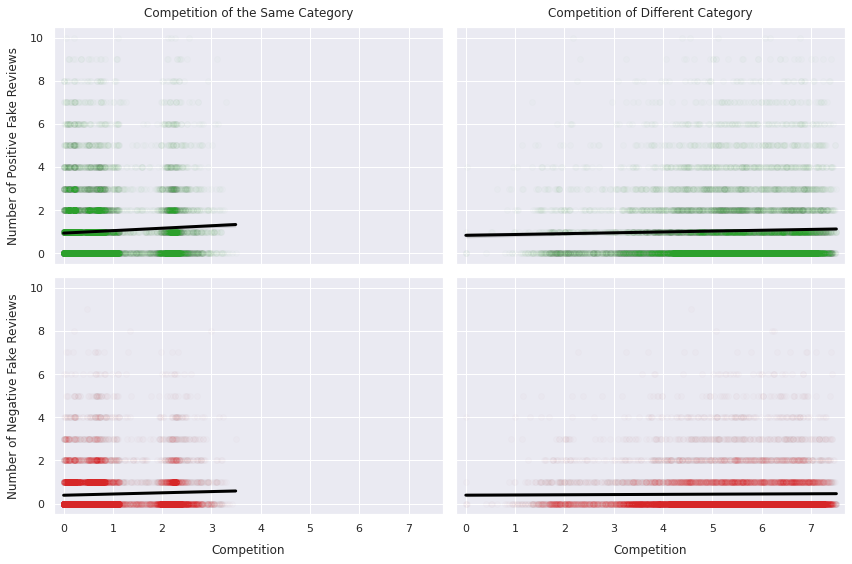

In [116]:
import seaborn as sns; sns.set_theme(color_codes=True)

fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(12,8))

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-0.2, 7.7)
custom_ylim = (-0.5, 10.5)
plt.setp(ax, xlim=custom_xlim)

# Setting the values for all axes.
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)


sns.regplot(x=competition_same_category/1000, y=df_test['positive_freview_count'], ax=ax[0,0],
            scatter_kws={'color':'tab:green', 'alpha':0.01}, line_kws={'color':'black', 'lw':3})

ax[0,0].set_title('Competition of the Same Category', pad=10)
ax[0,0].set_ylabel('Number of Positive Fake Reviews', labelpad=10)

sns.regplot(x=competition_diff_category/1000, y=df_test['positive_freview_count'], ax=ax[0,1],
            scatter_kws={'color':'tab:green', 'alpha':0.01}, line_kws={'color':'black', 'lw':3})
ax[0,1].set_title('Competition of Different Category', pad=10)
ax[0,1].set_ylabel('')


sns.regplot(x=competition_same_category/1000, y=df_test['negative_freview_count'], ax=ax[1,0],
            scatter_kws={'color':'tab:red', 'alpha':0.01}, line_kws={'color':'black', 'lw':3})
#ax[1,0].set_title('Negative Fake Reviews x Competition of the Same Category', pad=10)
ax[1,0].set_ylabel('Number of Negative Fake Reviews', labelpad=10)
ax[1,0].set_xlabel('Competition', labelpad=10)

sns.regplot(x=competition_diff_category/1000, y=df_test['negative_freview_count'], ax=ax[1,1],
            scatter_kws={'color':'tab:red', 'alpha':0.01}, line_kws={'color':'black', 'lw':3})
#ax[1,1].set_title('Negative Fake Reviews x Competition of Different Category', pad=10)
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('Competition', labelpad=10)

plt.tight_layout()
#plt.savefig('fig.png')
plt.show()